In [129]:
from trace_skeleton import *
import cv2
import random
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize, medial_axis
from sklearn.linear_model import LinearRegression

In [135]:
def zhang_suen_thinning(image):
    """
    Perform Zhang-Suen Thinning algorithm on a binary image.
    """
    def thinning_iteration(im, iter):
        marker = np.zeros(im.shape, dtype=np.uint8)
        for i in range(1, im.shape[0]-1):
            for j in range(1, im.shape[1]-1):
                p2,p3,p4 = im[i-1, j], im[i-1, j+1], im[i, j+1]
                p5,p6,p7 = im[i+1, j+1], im[i+1, j], im[i+1, j-1]
                p8,p9,p1 = im[i, j-1], im[i-1, j-1], im[i-1, j]

                A  = (p2 == 0 and p3 == 1) + (p3 == 0 and p4 == 1) + \
                     (p4 == 0 and p5 == 1) + (p5 == 0 and p6 == 1) + \
                     (p6 == 0 and p7 == 1) + (p7 == 0 and p8 == 1) + \
                     (p8 == 0 and p9 == 1) + (p9 == 0 and p1 == 1)
                B  = p2 + p3 + p4 + p5 + p6 + p7 + p8 + p9
                m1 = (p2 * p4 * p6) if iter == 0 else (p2 * p4 * p8)
                m2 = (p4 * p6 * p8) if iter == 0 else (p2 * p6 * p8)

                if A == 1 and (B >= 2 and B <= 6) and m1 == 0 and m2 == 0:
                    marker[i,j] = 1

        return im & ~marker

    image = image // 255  # Normalize pixels to 0 and 1
    prev = np.zeros(image.shape, np.uint8)
    diff = None

    while True:
        image = thinning_iteration(image, 0)
        image = thinning_iteration(image, 1)
        diff = np.abs(image - prev)
        prev = image.copy()
        if np.sum(diff) == 0:
            break

    return image * 255

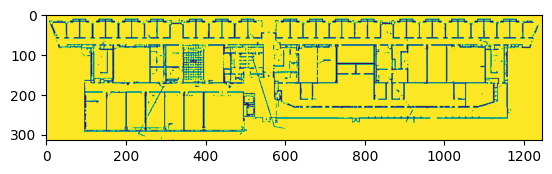

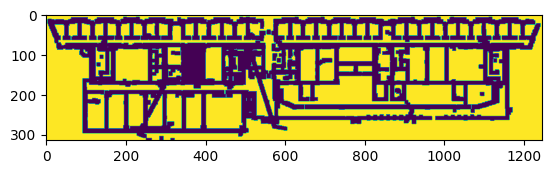

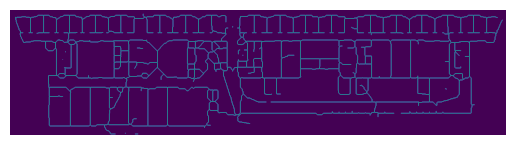

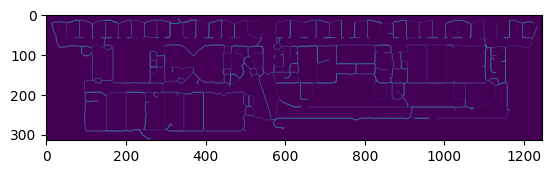

In [137]:
img_bgr = cv2.imread('rbg.png',1)
img = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(img)

kernel = np.ones((5,5),np.uint8)
img = cv2.erode(img,kernel,iterations = 2)

plt.figure()
plt.imshow(img)

_,img = cv2.threshold(img,10,1,cv2.THRESH_BINARY_INV)

blur = cv2.GaussianBlur(img,(5,5),0)

img = skeletonize(img,method='lee')

plt.figure()
plt.imshow(img)
plt.axis('off') 
plt.savefig('skeleton.png', bbox_inches='tight', pad_inches=0)

rects = []
polys = traceSkeleton(img,0,0,img.shape[1],img.shape[0],10,9999,rects)

for l in polys:
  c = (200*random.random(),200*random.random(),200*random.random())
  for i in range(0,len(l)-1):
    cv2.line(img,(l[i][0],l[i][1]),(l[i+1][0],l[i+1][1]),c)

plt.figure()
plt.imshow(img)


In [119]:
import random

def generate_svg_content(polylines):
    svg_content = '<svg width="1600" height="800" xmlns="http://www.w3.org/2000/svg">\n'
    for polyline in polylines:
        for i in range(len(polyline) - 1):
            x1, y1 = polyline[i]
            x2, y2 = polyline[i + 1]
            # For simplicity, we use a fixed color. If you want random colors, uncomment the next line.
            # color = f'rgb({random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)})'
            color = 'black'  # Fixed color
            svg_content += f'<line x1="{x1}" y1="{y1}" x2="{x2}" y2="{y2}" stroke="{color}" stroke-width="2"/>\n'
    svg_content += '</svg>'
    return svg_content


# Generate SVG content
svg_data = generate_svg_content(polys)

# Save to SVG file
svg_file_path = 'line_segments.svg'
with open(svg_file_path, 'w') as file:
    file.write(svg_data)

# Return the path to the saved SVG file
svg_file_path


'line_segments.svg'

In [120]:
def wall_filter(gray):
    """
    Filter walls
    Filter out walls from a grayscale image
    @Param image
    @Return image of walls
    """
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # # noise removal
    # kernel = np.ones((3,3),np.uint8)
    # opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1)

    sure_bg = cv2.dilate(thresh,kernel,iterations=3)

    dist_transform = cv2.distanceTransform(thresh,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(0.5*dist_transform,0.2*dist_transform.max(),255,0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    return unknown

True

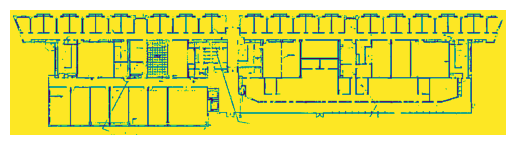

In [121]:
img = cv2.imread('reassembled_E2_2.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# wall_img = wall_filter(gray)
# wall_img = cv2.cvtColor(wall_img, cv2.COLOR_GRAY2BGR)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.figure()
plt.imshow(thresh)
plt.axis('off')
cv2.imwrite("rbg.png", thresh)